In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
# load your dataset
data_dir = os.path.join(os.getcwd(), 'data_files')

target_df = pd.read_csv(os.path.join(data_dir, 'targets.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df = pd.read_csv(os.path.join(data_dir, 'predictors.csv'), parse_dates=['USAGE_DATE'], index_col='USAGE_DATE')
predictor_df['Holiday'] = predictor_df['Holiday'].astype(int)

df = target_df.join(predictor_df).sort_index(ascending=True)

In [8]:
df_test = df[df.index >= pd.to_datetime('3/15/21')] 
df_train = df[df.index < pd.to_datetime('3/15/21')]

C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


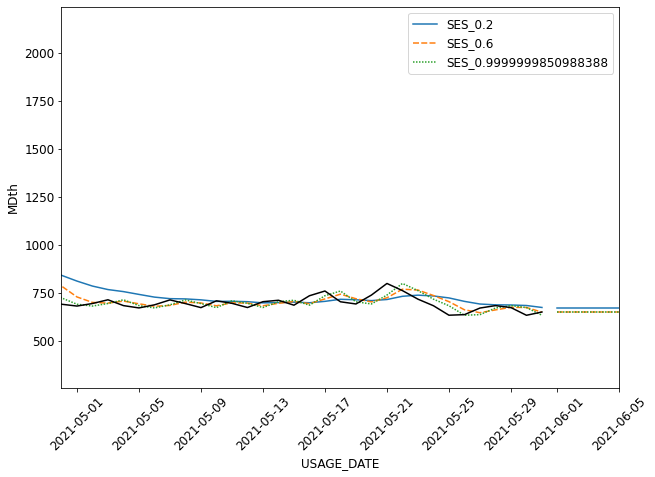

In [9]:
# Simple exponential smoothing
forecast_days = 5
forecast_dates = pd.date_range(start=df.index.max(), end=df.index.max()+pd.DateOffset(days=forecast_days))[1:]

# exponential smoothing requires sorting dates with latest at the bottom!!!!
fit1 = ExponentialSmoothing(df['SoCal_TOTAL'], initialization_method="heuristic").fit(smoothing_level=0.2,optimized=False)
fit2 = ExponentialSmoothing(df['SoCal_TOTAL'], initialization_method="heuristic").fit(smoothing_level=0.6,optimized=False)
fit3 = ExponentialSmoothing(df['SoCal_TOTAL'], initialization_method="estimated").fit()

fit_df = pd.DataFrame({'SES_0.2':fit1.fittedvalues, 
                       'SES_0.6': fit2.fittedvalues, 
                       'SES_' +str(fit3.model.params['smoothing_level']): fit3.fittedvalues})

forecast_df = pd.DataFrame({'USAGE_DATE': forecast_dates, 
                            'SES_0.2':fit1.forecast(forecast_days),
                            'SES_0.6': fit2.forecast(forecast_days), 
                            'SES_' +str(fit3.model.params['smoothing_level']): fit3.forecast(forecast_days)}).set_index('USAGE_DATE')

plt.figure(figsize=(10, 7))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=fit_df, legend=True)
sns.lineplot(data=df, x=df.index, y='SoCal_TOTAL', color='k', legend=True)
sns.lineplot(data=forecast_df, legend=False)
plt.xticks(rotation=45), plt.xlim([fit_df.index.max() - pd.DateOffset(months=1), forecast_df.index.max()])
plt.ylabel('MDth')
plt.show()

C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_ret

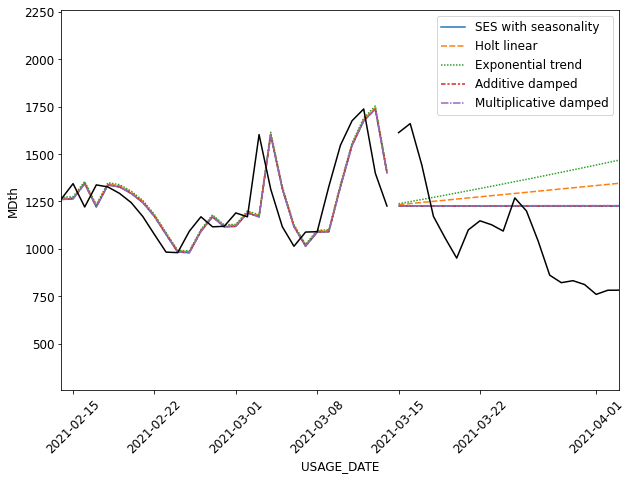

In [10]:
forecast_days = 20
forecast_dates = pd.date_range(start = df_train.index.max(), end = df_train.index.max()+pd.DateOffset(days=forecast_days))[1:]

ses = ExponentialSmoothing(df_train['SoCal_TOTAL'], initialization_method="estimated").fit()
holt1 = Holt(df_train['SoCal_TOTAL'], initialization_method="estimated").fit()
holt2 = Holt(df_train['SoCal_TOTAL'], exponential=True, initialization_method="estimated").fit()
holt3 = Holt(df_train['SoCal_TOTAL'], damped_trend=True, initialization_method="estimated").fit(damping_trend=0.98)
holt4 = Holt(df_train['SoCal_TOTAL'], exponential=True, damped_trend=True, initialization_method="estimated").fit()


holt_df = pd.DataFrame({'USAGE_DATE': df_train.index,
                        'SES with seasonality': ses.fittedvalues,
                        'Holt linear': holt1.fittedvalues, 
                        'Exponential trend': holt2.fittedvalues, 
                        'Additive damped': holt3.fittedvalues,
                        'Multiplicative damped': holt4.fittedvalues})

holt_fcst_df = pd.DataFrame({'USAGE_DATE': forecast_dates, 
                             'SES with seasonality': ses.forecast(forecast_days),
                             'Holt linear':holt1.forecast(forecast_days),
                             'Exponential': holt2.forecast(forecast_days), 
                             'Additive damped': holt3.forecast(forecast_days),
                             'Multiplicative damped': holt4.forecast(forecast_days)}).set_index('USAGE_DATE')


plt.figure(figsize=(10, 7))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=holt_df, legend=True)
sns.lineplot(data=df_train, x=df_train.index, y='SoCal_TOTAL', color='k', legend=True)
sns.lineplot(data=holt_fcst_df, legend=False)
sns.lineplot(data=df_test, x=df_test.index, y='SoCal_TOTAL', color='k', legend=True)
plt.xticks(rotation=45), plt.xlim([holt_df.index.max() - pd.DateOffset(months=1), holt_fcst_df.index.max()])
plt.ylabel('MDth')
plt.show()

C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\JCheung1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


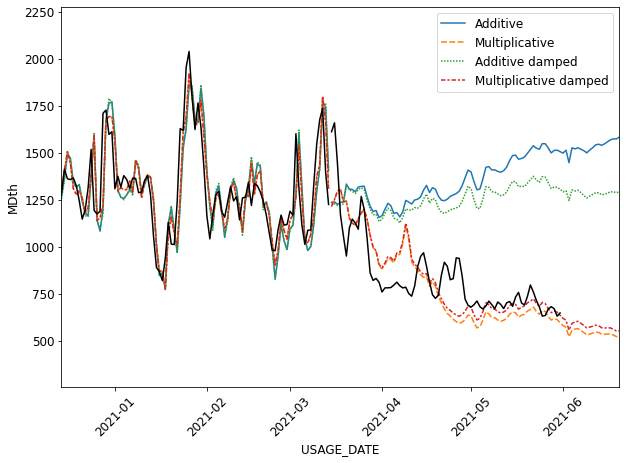

In [16]:
forecast_days = 20
forecast_dates = pd.date_range(start = df_train.index.max(), end = df_test.index.max()+pd.DateOffset(days=forecast_days))[1:]

seasonal1= ExponentialSmoothing(df_train['SoCal_TOTAL'], seasonal_periods=365, seasonal='add', trend='add', initialization_method="estimated").fit()
seasonal2 = ExponentialSmoothing(df_train['SoCal_TOTAL'], seasonal_periods=365, seasonal='mul', trend='add', initialization_method="estimated").fit()
seasonal3 = ExponentialSmoothing(df_train['SoCal_TOTAL'], seasonal_periods=365, seasonal='add', damped_trend=True, trend='add', initialization_method="estimated").fit()
seasonal4 = ExponentialSmoothing(df_train['SoCal_TOTAL'], seasonal_periods=365, seasonal='mul', damped_trend=True, trend='add', initialization_method="estimated").fit()

seasonal_df = pd.DataFrame({'USAGE_DATE': df_train.index,
                        'Additive': seasonal1.fittedvalues,
                        'Multiplicative': seasonal2.fittedvalues, 
                        'Additive damped': seasonal3.fittedvalues, 
                        'Multiplicative damped': seasonal4.fittedvalues})

seasonal_fcst_df = pd.DataFrame({'USAGE_DATE': forecast_dates, 
                             'Additive': seasonal1.forecast(len(forecast_dates)),
                             'Multiplicative':seasonal2.forecast(len(forecast_dates)),
                             'Additive damped': seasonal3.forecast(len(forecast_dates)), 
                             'Multiplicative damped': seasonal4.forecast(len(forecast_dates))}).set_index('USAGE_DATE')


plt.figure(figsize=(10, 7))
plt.rcParams.update({'font.size': 12})
sns.lineplot(data=seasonal_df, legend=True)
sns.lineplot(data=df_train, x=df_train.index, y='SoCal_TOTAL', color='k', legend=True)
sns.lineplot(data=seasonal_fcst_df, legend=False)
sns.lineplot(data=df_test, x=df_test.index, y='SoCal_TOTAL', color='k', legend=True)
plt.xticks(rotation=45), plt.xlim([seasonal_df.index.max() - pd.DateOffset(months=3), seasonal_fcst_df.index.max()])
plt.ylabel('MDth')
plt.show()

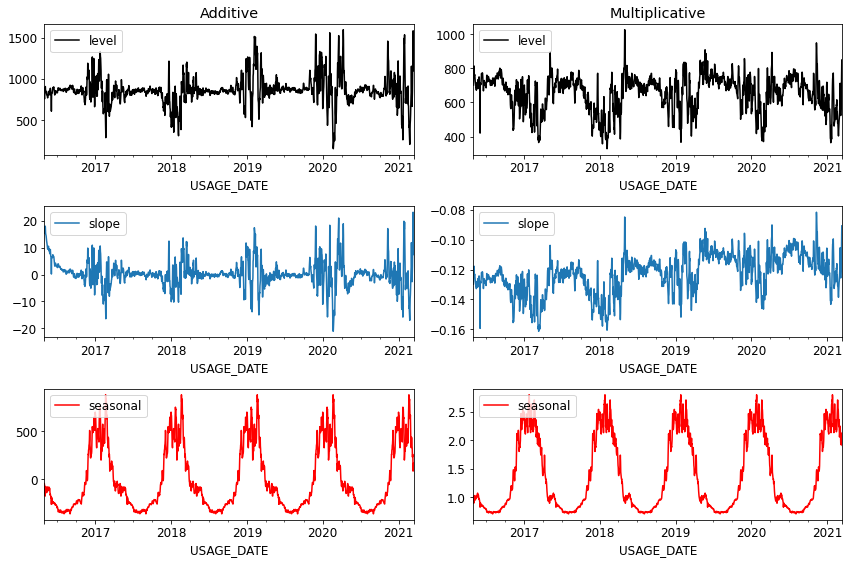

(None, None)

In [17]:
states1 = pd.DataFrame(np.c_[seasonal1.level, seasonal1.trend, seasonal1.season], columns=['level','slope','seasonal'], index=df_train.index)
states2 = pd.DataFrame(np.c_[seasonal2.level, seasonal2.trend, seasonal2.season], columns=['level','slope','seasonal'], index=df_train.index)
fig, [[ax1, ax4],[ax2, ax5], [ax3, ax6]] = plt.subplots(3, 2, figsize=(12,8))
states1[['level']].plot(ax=ax1, color='k'), ax1.set_title('Additive')
states1[['slope']].plot(ax=ax2)
states1[['seasonal']].plot(ax=ax3, color='r')
states2[['level']].plot(ax=ax4, color='k'), ax4.set_title('Multiplicative')
states2[['slope']].plot(ax=ax5)
states2[['seasonal']].plot(ax=ax6, color='r')
plt.tight_layout(), plt.show()

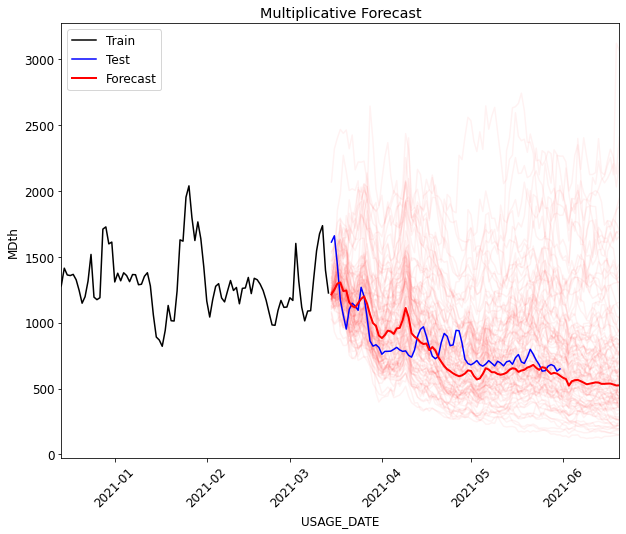

In [82]:
simulations = seasonal2.simulate(len(forecast_dates), anchor=df_test.index.min(), repetitions=100, error='mul', random_errors='bootstrap')
plt.figure(figsize=(10,8))
plt.plot(simulations, c='r', alpha=0.05)
plt.plot(df_train['SoCal_TOTAL'], c='k', label='Train')
plt.plot(df_test['SoCal_TOTAL'], c='b', label='Test')
plt.plot(seasonal_fcst_df['Multiplicative'],c='r', linewidth=2, label='Forecast')
plt.xticks(rotation=45), plt.xlim([seasonal_df.index.max() - pd.DateOffset(months=3), seasonal_fcst_df.index.max()])
plt.xlabel('USAGE_DATE'), plt.ylabel('MDth'), plt.title('Multiplicative Forecast')
plt.legend(loc='upper left')
plt.show()

In [85]:
seasonal1.params

{'smoothing_level': 0.9649580418817181,
 'smoothing_trend': 0.029228956611093947,
 'smoothing_seasonal': 0.0017376979290580719,
 'damping_trend': nan,
 'initial_level': 849.5290916275967,
 'initial_trend': 19.03712951462347,
 'initial_seasons': array([ -44.07795809,  -61.66953689, -121.46211605, -171.95095486,
        -174.52621839, -128.60133363,  -74.41881939,  -78.19939042,
        -103.61154726, -110.65494073, -126.16666777, -138.18245373,
        -137.21863402, -126.0852849 ,  -98.82915183,  -79.04273779,
         -85.02011206, -114.05290377, -117.64527293, -117.72615555,
        -105.00577665,  -91.97369083,  -80.10256627, -100.41200578,
        -113.3610046 ,  -91.00699378,  -98.99239083, -128.49193531,
        -163.18806178, -157.03492694, -163.38555034, -178.4844268 ,
        -193.96899652, -185.693987  , -259.98248954, -188.18829031,
        -201.72491914, -203.00041058, -218.38328834, -233.49040563,
        -252.54551429, -244.63403923, -240.10582188, -232.59403997,
        